## 1. Import Required Libraries and Data

In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timezone

In [2]:
# Set directory
path = 'C:/Users/cbrut/OneDrive/Documentos/GitHubStarPredictor'
os.chdir(path)

# Import data
git_data = pd.read_csv('data/github-repo-data.csv')

## 2. Exploratory Data Analysis and Data Preprocessing

In [3]:
# Check the general info
print(git_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75260 entries, 0 to 75259
Data columns (total 24 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       75260 non-null  int64  
 1   Name             75260 non-null  object 
 2   Description      72441 non-null  object 
 3   URL              75260 non-null  object 
 4   Created At       75260 non-null  object 
 5   Updated At       75260 non-null  object 
 6   Homepage         27338 non-null  object 
 7   Size             75260 non-null  int64  
 8   Stars            75260 non-null  int64  
 9   Forks            75259 non-null  float64
 10  Issues           75260 non-null  int64  
 11  Language         69683 non-null  object 
 12  License          56573 non-null  object 
 13  Topics           75260 non-null  object 
 14  Has Issues       75260 non-null  bool   
 15  Has Projects     75260 non-null  bool   
 16  Has Downloads    75260 non-null  bool   
 17  Has Wiki    

In [4]:
# Check for duplicates in the dataset
duplicates = git_data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

if duplicates > 0:
    git_data = git_data.drop_duplicates()

Number of duplicate rows: 0


### A. Target variable: Stars

#### 1. Checking inconsistencies 


In [5]:
# Remove rows with missing values in 'Stars' column
null_target = git_data['Stars'].isnull().sum()
print(f"Number of missing values in target variable: {null_target}")

if null_target > 0:
    git_data = git_data.dropna(subset=['Stars'])

Number of missing values in target variable: 0


In [6]:
# Remove rows with negative values in 'Stars' column
negative_target = (git_data['Stars'] < 0).sum()
print(f"Number of negative values in target variable: {negative_target}")
if negative_target > 0:
    git_data = git_data[git_data['Stars'] >= 0]

Number of negative values in target variable: 0


#### 2. KDE Plot

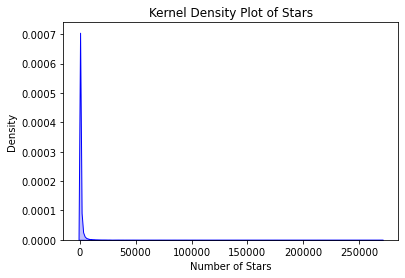

In [7]:
sns.kdeplot(git_data['Stars'], shade=True, color='blue')
plt.title('Kernel Density Plot of Stars')
plt.xlabel('Number of Stars')
plt.ylabel('Density')
plt.show()

#### 3. Boxplot

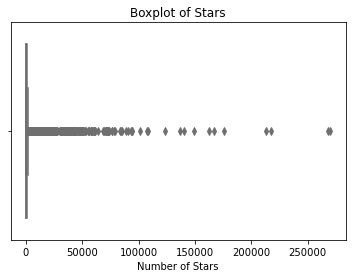

In [8]:
sns.boxplot(x=git_data['Stars'], color='skyblue')
plt.title('Boxplot of Stars')
plt.xlabel('Number of Stars')
plt.show()

#### 4. Percentile Table

In [9]:
percentiles_stars = git_data['Stars'].quantile([0.01, 0.05, 0.1, 0.25, 
                                                0.5, 0.75, 0.9, 0.95, 
                                                0.99]).to_frame(name='Percentiles')
print(percentiles_stars)

      Percentiles
0.01       169.00
0.05       178.00
0.10       190.00
0.25       237.00
0.50       378.00
0.75       799.00
0.90      2036.10
0.95      3780.10
0.99     12715.33


We can observe that the stars variable has a highly skewed distribution, with most repositories having a low number of stars and a small number of repositories attracting a disproportionately large number. Hence, we apply log transformation.

#### 5. Apply Log-transformation

In [10]:
git_data['Stars'] = np.log(git_data['Stars'] + 1)

### B. Features variables

#### 1. Irrelevant Columns

In [11]:
# Remove irrelevant columns
git_data = git_data.drop(['Name', 'Homepage', 'URL', 'Default Branch'], axis=1)

#### 2. Numerical Features

In [12]:
numerical_features = ['Size', 'Forks', 'Issues']

# Basic description
print(git_data[numerical_features].describe())

               Size          Forks        Issues
count  7.526000e+04   75259.000000  75260.000000
mean   5.327446e+04     230.719183     38.221579
std    6.309907e+05    1040.149727    205.881922
min    0.000000e+00      -5.000000      0.000000
25%    3.740000e+02      39.000000      3.000000
50%    2.361000e+03      79.000000     10.000000
75%    1.497400e+04     175.000000     28.000000
max    1.024891e+08  142778.000000  20875.000000


In [13]:
# Check negative values
print((git_data[numerical_features] < 0).sum())

# Impute the absolute value for negative values in Forks
git_data['Forks'] = git_data['Forks'].apply(lambda x: abs(x) if x < 0 else x)

Size      0
Forks     2
Issues    0
dtype: int64


In [14]:
# Check missing values
print(git_data[numerical_features].isnull().sum())

# Impute the median for missing values in Forks. The median is chosen becauseit is robust to outliers
git_data['Forks'].fillna(git_data['Forks'].median(), inplace=True)

Size      0
Forks     1
Issues    0
dtype: int64


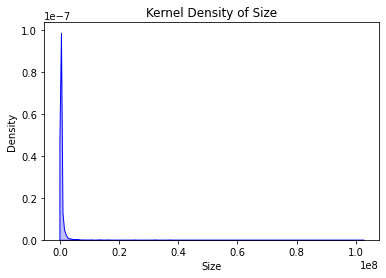

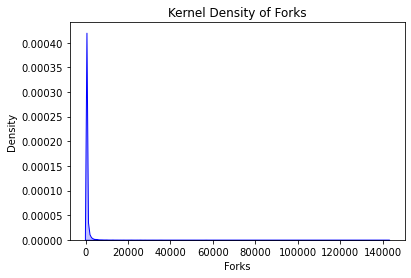

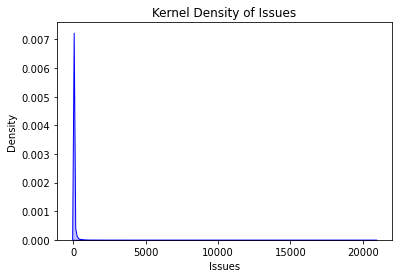

In [15]:
# KDE Plots
for feature in numerical_features:
    sns.kdeplot(git_data[feature], shade=True, color='blue')
    plt.title(f"Kernel Density of {feature}")
    plt.xlabel(f"{feature}")
    plt.ylabel('Density')
    plt.show()

We also observe that numerical features has a highly skewed distribution. 


In [16]:
# Apply Log-transformation
for feature in numerical_features:
    git_data[feature] = np.log(git_data[feature] + 1)

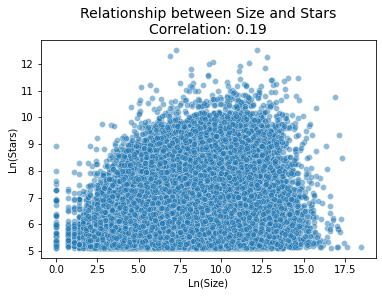

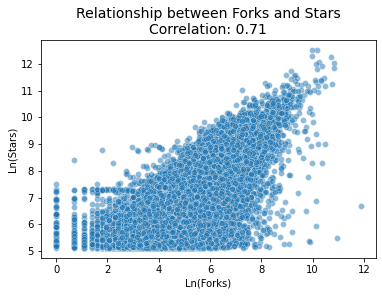

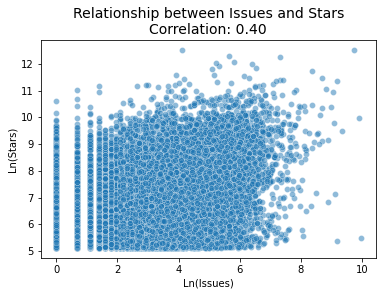

In [17]:
# Scatter plots between numerical features and the target 

for feature in numerical_features:
    # Calculate correlation between feature and target
    correlation = git_data[[feature, 'Stars']].corr().iloc[0, 1]
    
    # Scatterplot
    sns.scatterplot(data=git_data, x=feature, y='Stars', alpha=0.5)
    plt.title(f'Relationship between {feature} and Stars\nCorrelation: {correlation:.2f}', fontsize=14)
    plt.xlabel(f'Ln({feature})')
    plt.ylabel('Ln(Stars)')
    plt.show()

#### 3. Boolean Features

In [18]:
#Convert boolean features to a numerical features (1 for True, 0 for False)
boolean_features = ['Has Issues', 'Has Projects', 'Has Downloads', 'Has Wiki', 
                'Has Pages', 'Has Discussions', 'Is Fork', 'Is Archived', 'Is Template']

for feature in boolean_features:
    git_data[feature] = git_data[feature].astype(int)
    
    # Check that the features has variation
    print(feature + ": " + str(git_data[feature].unique()))

Has Issues: [1 0]
Has Projects: [1 0]
Has Downloads: [1 0]
Has Wiki: [1 0]
Has Pages: [0 1]
Has Discussions: [1 0]
Is Fork: [0]
Is Archived: [0 1]
Is Template: [0 1]


In [19]:
# Is Fork has no variation so we drop this column
git_data = git_data.drop(['Is Fork'], axis=1)

#### 4. Date Features

In [20]:
# Convert 'Created At' and 'Updated At' to datetime format
git_data['Created At'] = pd.to_datetime(git_data['Created At'])
git_data['Updated At'] = pd.to_datetime(git_data['Updated At'])

# Get the current date
current_date = datetime.now(tz=timezone.utc)  # Use timezone-naive current time for compatibility

# Create the 'Age' variable (difference in days between the current date and 'Created At')
git_data['Age'] = (current_date - git_data['Created At']).dt.days

# Create the 'Last Update' variable (difference in days between the current date and 'Updated At')
git_data['Last Update'] = (current_date - git_data['Updated At']).dt.days

# Display the first few rows of the dataframe with the new columns
print(git_data[['Created At', 'Updated At', 'Age', 'Last Update']].head())

# Drop date columns
git_data = git_data.drop(['Created At', 'Updated At'], axis=1)

                 Created At                Updated At   Age  Last Update
0 2019-12-26 14:56:29+00:00 2023-09-20 18:03:09+00:00  1805          441
1 2017-11-21 14:09:27+00:00 2023-09-16 21:08:32+00:00  2570          445
2 2016-10-12 15:26:32+00:00 2023-08-17 13:22:19+00:00  2975          475
3 2014-05-23 16:17:24+00:00 2023-09-08 16:41:08+00:00  3848          453
4 2021-10-19 06:14:07+00:00 2023-09-15 03:45:32+00:00  1143          447


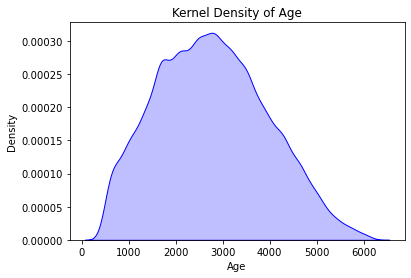

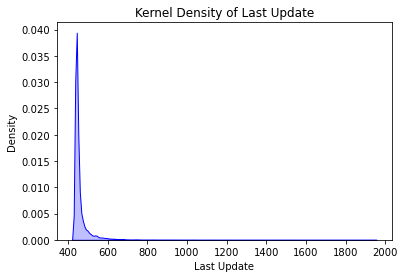

In [21]:
# KDE Plots
date_features = ['Age', 'Last Update']

for feature in date_features:
    sns.kdeplot(git_data[feature], shade=True, color='blue')
    plt.title(f"Kernel Density of {feature}")
    plt.xlabel(f"{feature}")
    plt.ylabel('Density')
    plt.show()

In [22]:
# Apply Log-transformation
for feature in date_features:
    git_data[feature] = np.log(git_data[feature] + 1)

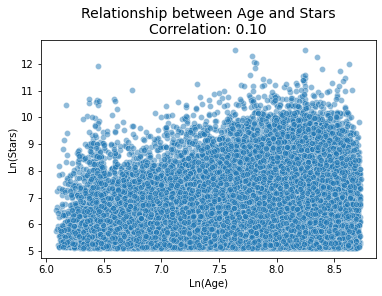

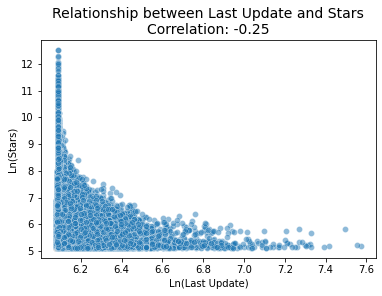

In [23]:
# Scatter plots between date features and the target 
for feature in date_features:
    # Calculate correlation between feature and target
    correlation = git_data[[feature, 'Stars']].corr().iloc[0, 1]
    
    # Scatterplot
    sns.scatterplot(data=git_data, x=feature, y='Stars', alpha=0.5)
    plt.title(f'Relationship between {feature} and Stars\nCorrelation: {correlation:.2f}', fontsize=14)
    plt.xlabel(f'Ln({feature})')
    plt.ylabel('Ln(Stars)')
    plt.show()

#### 5. Text Features

In [24]:
# Replace null values with an empty string 
print(git_data['Description'].isna().sum())
git_data['Description'].fillna('', inplace=True)


2819


In [25]:
# Create a new feature 'Description Length' that counts the number of characters 
git_data['Description Length'] = git_data['Description'].apply(len)

# Possible extensions: remove stop words, exclude punctuation and spaces, stemming, lemmatization, sentiment analysis...

# Drop column
git_data = git_data.drop(['Description'], axis=1)

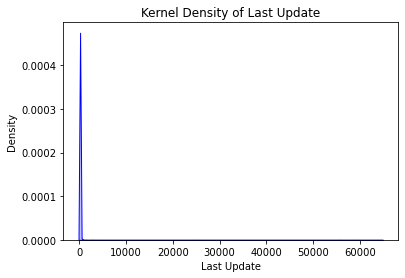

In [26]:
# KDE Plot
sns.kdeplot(git_data['Description Length'], shade=True, color='blue')
plt.title(f"Kernel Density of {feature}")
plt.xlabel(f"{feature}")
plt.ylabel('Density')
plt.show()

In [27]:
# Apply Log-transformation
git_data['Description Length'] = np.log(git_data['Description Length'] + 1)

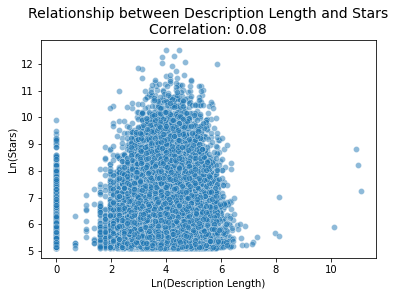

In [28]:
# Scatter plots between date features and the target 
# Calculate correlation between feature and target
correlation = git_data[['Description Length', 'Stars']].corr().iloc[0, 1]
    
# Scatterplot
sns.scatterplot(data=git_data, x='Description Length', y='Stars', alpha=0.5)
plt.title(f'Relationship between Description Length and Stars\nCorrelation: {correlation:.2f}', fontsize=14)
plt.xlabel(f'Ln(Description Length)')
plt.ylabel('Ln(Stars)')
plt.show()

#### 6.  Categorical Features

In [29]:
categorical_features = ['Language', 'License', 'Topics']

# Check missing values
print(git_data[categorical_features].isnull().sum())

# Fill missing values
git_data['Language'].fillna("Unknown", inplace=True)
git_data['License'].fillna("NOASSERTION", inplace=True)

Language     5577
License     18687
Topics          0
dtype: int64


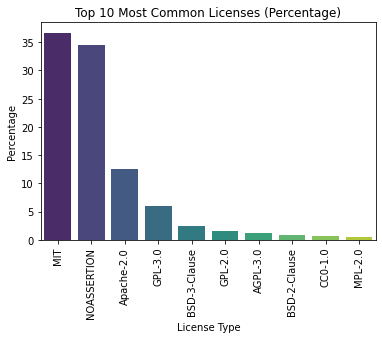

   License MIT  License NOASSERTION  License Apache-2.0  License GPL-3.0  \
0            0                    0                   0                1   
1            0                    0                   0                0   
2            1                    0                   0                0   
3            0                    1                   0                0   
4            1                    0                   0                0   

   License BSD-3-Clause  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  


In [30]:
# Encode categorical features  
"""
License 
"""
# Show the top 10 most frequent licenses in a bar plot
license_counts = git_data['License'].value_counts(normalize=True) * 100  # Convertir a porcentaje
top_licenses = license_counts.head(10)

sns.barplot(x=top_licenses.index, y=top_licenses.values, palette='viridis')
plt.title('Top 10 Most Common Licenses (Percentage)')
plt.xlabel('License Type')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.show()

# Identify the top 5 most common licenses
top_5_licenses = git_data['License'].value_counts().head(5).index

# Create dummy variables for each of the top 5 licenses
for license_type in top_5_licenses:
    column_name = f'License {license_type}'
    git_data[column_name] = (git_data['License'] == license_type).astype(int)

# Verify the new columns
print(git_data[[f'License {license}' for license in top_5_licenses]].head())

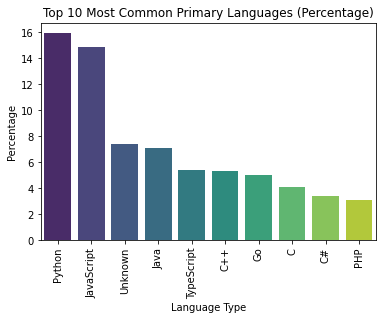

   Language Python  Language JavaScript  Language Unknown  Language Java  \
0                0                    1                 0              0   
1                1                    0                 0              0   
2                0                    1                 0              0   
3                0                    1                 0              0   
4                1                    0                 0              0   

   Language TypeScript  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  


In [31]:
"""
Language 
"""
# Show the top 10 most frequent primary languages in a bar plot
Language_counts = git_data['Language'].value_counts(normalize=True) * 100  # Convertir a porcentaje
top_Languages = Language_counts.head(10)

sns.barplot(x=top_Languages.index, y=top_Languages.values, palette='viridis')
plt.title('Top 10 Most Common Primary Languages (Percentage)')
plt.xlabel('Language Type')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.show()

# Identify the top 5 most common Languages
top_5_Languages = git_data['Language'].value_counts().head(5).index

# Create dummy variables for each of the top 5 Languages
for Language_type in top_5_Languages:
    column_name = f'Language {Language_type}'
    git_data[column_name] = (git_data['Language'] == Language_type).astype(int)

# Verify the new columns
print(git_data[[f'Language {Language}' for Language in top_5_Languages]].head())

In [32]:
# Drop categorical features
git_data = git_data.drop(categorical_features, axis=1)

#### 7. Final check

In [33]:
# Loop to check if there is still any boolean or categorical variables
for column in git_data.columns:
    if git_data[column].dtype == 'bool':
        print(f"Boolean column: {column}")
    elif git_data[column].dtype == 'object':
        print(f"Categorical column: {column}")

###  C. Correlations

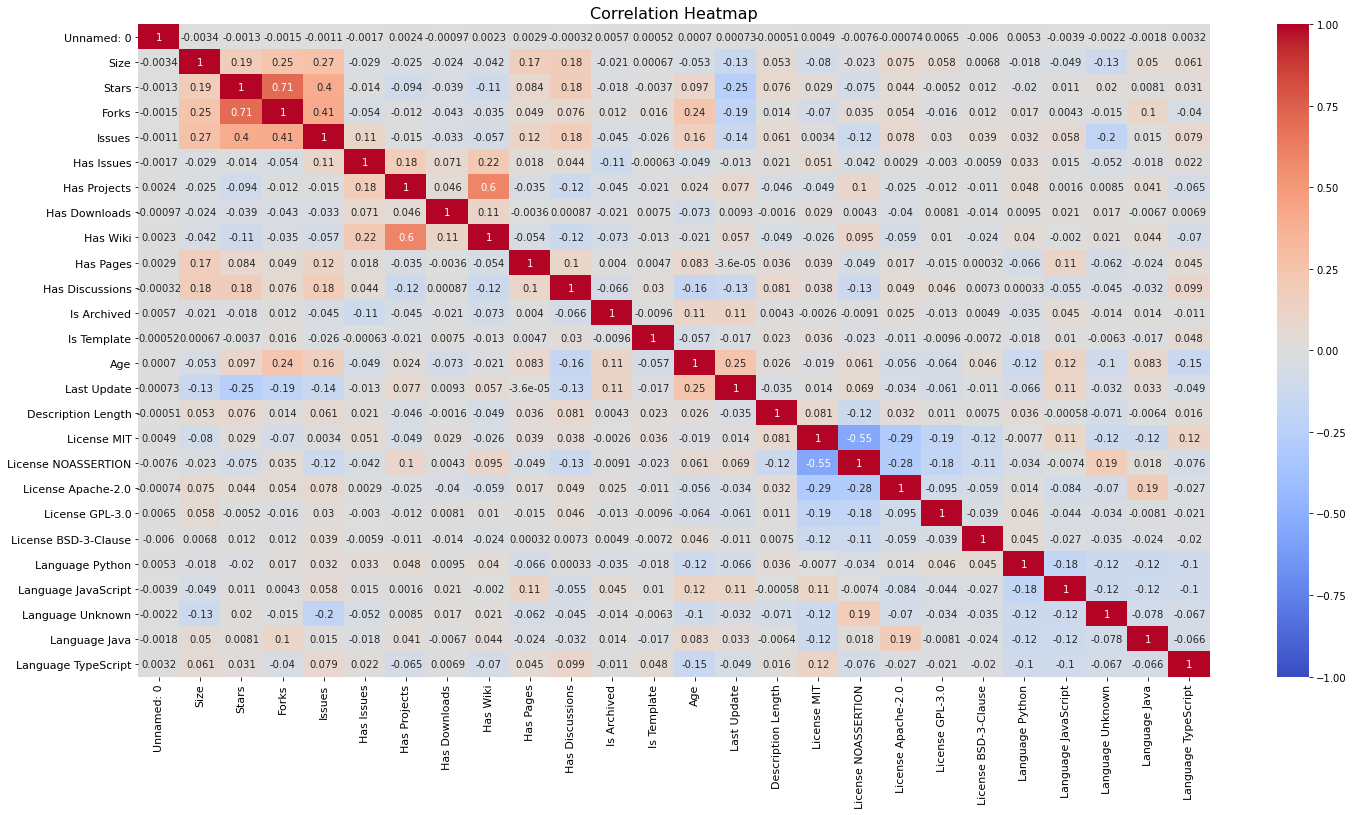

In [34]:
# Correlation Heatmap 
plt.figure(figsize=(24, 12))
sns.heatmap(
    git_data.corr(), 
    annot=True, 
    cmap='coolwarm', 
    vmin=-1, vmax=1, 
    cbar=True
)
plt.xticks(rotation=90, fontsize=11)
plt.yticks(rotation=0, fontsize=11)
plt.title('Correlation Heatmap', fontsize=16)
plt.show()


In [35]:
## Correlation of 'Stars' with other features
correlation_with_stars = git_data.corr()['Stars'].sort_values(ascending=False)
print("Correlation between Stars and other features:")
print(correlation_with_stars)

Correlation between Stars and other features:
Stars                   1.000000
Forks                   0.707684
Issues                  0.404749
Size                    0.191059
Has Discussions         0.177540
Age                     0.096508
Has Pages               0.083721
Description Length      0.076031
License Apache-2.0      0.044059
Language TypeScript     0.031239
License MIT             0.029363
Language Unknown        0.019942
License BSD-3-Clause    0.011722
Language JavaScript     0.010669
Language Java           0.008056
Unnamed: 0             -0.001285
Is Template            -0.003723
License GPL-3.0        -0.005228
Has Issues             -0.013597
Is Archived            -0.018359
Language Python        -0.019914
Has Downloads          -0.038671
License NOASSERTION    -0.075008
Has Projects           -0.094250
Has Wiki               -0.109258
Last Update            -0.253498
Name: Stars, dtype: float64


### D. Save Final Dataset 

In [36]:
git_data.to_csv('data/github-repo-data-processed.csv')